In [13]:
 #%%writefile car_following_models_IDM.py
##This version has modified the intial state for each model
    
import math
import numpy as np
from qpsolvers import solve_qp
import timeit
import matplotlib.pyplot as plt
from traj_data import *

def cal_derivative(f, dt):
    T = len(f)
    df = np.zeros(T)
    d2f = np.zeros(T)
    for t in range(1, T-1):
        df[t] = (f[t+1] - f[t-1]) / (2*dt)
        d2f[t] = (f[t+1] + f[t-1] - 2*f[t]) / (dt*dt)
    df[0] = (f[1] - f[0]) / dt
    df[T-1] = (f[T-1] - f[T-2]) / dt
    
    d2f[0] = d2f[1]
    d2f[T-1] = d2f[T-2]
    return df,d2f

def AccQualSolver(ts, K, xm, tau, alpha, R, amin, amax):

    Ad = np.array([
                [1, ts],
                [0, 1]])
    Bd = np.array([
        [-tau*ts - ts - 0.5*ts*ts,  
         -ts]]).transpose()
    Dd = np.array([
        [ts + 0.5*ts*ts,
         ts]]).transpose()
    I2 = np.identity(2)
    Q = np.array([
                [1, 0],
                [0, alpha]])

    A = np.zeros([2*K+2, 3*K+2])
    B = np.zeros([2*K+2,1])
    H = np.zeros([3*K+2, 3*K+2])
    A[0:2,0:2] = I2
    B[0:2,0:1] = xm.T
    H[0:2,0:2] = Q
    for k in range(K):
        A[2*k+2:2*(k+1)+2, 2*k:2*(k+1)] = Ad
        A[2*k+2:2*(k+1)+2, 2*k+2:2*(k+1)+2] = - I2
        A[2*k+2:2*(k+1)+2, 2*K+2+k:2*K+k+3] = Bd

        H[2*k+2:2*(k+1)+2, 2*k+2:2*(k+1)+2] = Q
        H[2*K+2+k,2*K+2+k] = R
    
    lb = np.zeros(3*K+2) - np.inf
    ub = np.zeros(3*K+2) + np.inf
    for k in range(2*K+2, 3*K+2):
        lb[k] = amin
        ub[k] = amax
    YY = solve_qp(H, np.zeros(3*K+2),np.zeros(3*K+2),[0], A, B.flatten(), lb, ub)
    return YY[2*K+2]

class CF_Model:
    def __init__(self, sample_time_step, model_name = 'LL'):
        self.time_step = sample_time_step
        self.model_name = model_name
        if model_name == 'FVM':
            self.parameter_dim = 6
            self.parameter_name = ['tau', 'lambda', 'V1', 'V2', 'lint', 'beta']
        if model_name == 'FVM2':
            self.parameter_dim = 6
            self.parameter_name = ['gamma', 'lambda', 'V1', 'V2', 'alpha', 'beta']
        if model_name == 'LL':
            self.parameter_dim = 4
            self.parameter_name = ['tau', 'Ks', 'Kv', 'l']
        if model_name == 'LLCS':
            self.parameter_dim = 3
            self.parameter_name = ['s0', 'Ks', 'Kv']
        if model_name == 'HL':
            self.parameter_dim = 6
            elf.parameter_name = ['tau', 'TT', 'Ks', 'Kv', 'Ka', 'l']
        if model_name == 'MPC':
            self.parameter_dim = 6
            self.parameter_name = ['tau', 'R', 'alpha', 'l', 'amin', 'amax']
        if model_name == 'IDM':
            self.parameter_dim = 6
            self.parameter_name = ['a', 'b', 'v0', 'tau', 's0', 'delta']
        if model_name == 'MPCAB':
            self.parameter_dim = 6
            self.parameter_name = ['tau', 'R', 'alpha', 'l', 'amin', 'amax']
        if model_name == 'MPCABF':
            self.parameter_dim = 8
            self.parameter_name = ['tau', 'R', 'alpha', 'l', 'amin', 'amax','accmin','accmax']  
        if model_name == 'OVM':
            self.parameter_dim = 6
            self.parameter_name = ['k', 'V1', 'V2', 'C1', 'C2', 'tau']
        if model_name == 'GFM':
            self.parameter_dim = 7
            self.parameter_name = ['k', 'lam', 'V1', 'V2', 'C1', 'C2', 'tau']    
           
    def single_simulation(self, traj_leader, traj_follower_benchmark, parameters):
        self.parameters = parameters
        traj_follower = TrajVector(self.time_step)
        traj_follower = self.simulator(traj_leader, traj_follower_benchmark)
        return traj_follower
   
    def batch_simulation(self, traj_leader_vec, traj_follower_benchmark_vec, parameters):
       # tic = timeit.default_timer()
        self.parameters = parameters
        self.traj_leader_vector = traj_leader_vec
        self.traj_follower_benchmark_vector = traj_follower_benchmark_vec
        self.traj_follower_vector = TrajVector(self.time_step)
        for i in range(traj_leader_vec.num_veh):
            self.traj_follower_vector.veh[i] = self.simulator(traj_leader_vec.veh[i], traj_follower_benchmark_vec.veh[i])
            self.traj_follower_vector.num_veh += 1
        self.traj_follower_vector.sample_points = self.traj_follower_vector.veh[0].sample_points
       # toc = timeit.default_timer()
       # print(toc - tic)
        return self.traj_follower_vector
   
   
    def downsample_simulation(self, traj_leader_vec, traj_follower_benchmark_vec, parameters, sample_id):
        self.parameters = parameters
        self.traj_leader_vector = traj_leader_vec
       # sample_id = np.random.randint(traj_leader_vec.num_veh)
        self.traj_follower_vector = TrajVector(self.time_step)
        self.traj_follower_vector.veh[0] = self.simulator(traj_leader_vec.veh[sample_id], traj_follower_benchmark_vec.veh[sample_id])
        self.traj_follower_vector.num_veh = traj_leader_vec.num_veh
        self.traj_follower_vector.sample_points = self.traj_follower_vector.veh[0].sample_points
        self.traj_follower_vector.sample_id = sample_id
        return self.traj_follower_vector
       
    def simulator(self, traj_leader, traj_follower_benchmark):
       
        self.leader_position = traj_leader.position
        self.leader_speed = traj_leader.speed
        self.leader_acceleration = traj_leader.acceleration
       
        self.follower_benchmark_position = traj_follower_benchmark.position
        self.follower_benchmark_speed = traj_follower_benchmark.speed
        self.follower_benchmark_acceleration = traj_follower_benchmark.acceleration
       
        self.sample_points = len(self.leader_position)
       
        if self.model_name == 'FVM':
           ###  Simulation Process   
           
           # gamma = self.parameters[0]
           # lam = self.parameters[1]
           # V1 = self.parameters[2]
           # V2 = self.parameters[3]
           # alpha = self.parameters[4]
           # beta = self.parameters[5]
           
            tau = self.parameters[0]
            lam = self.parameters[1]
            V1 = self.parameters[2]
            V2 = self.parameters[3]
            lint = self.parameters[4]
            beta = self.parameters[5]

            ts = self.time_step

           # input trajectory analysis
            xl = self.leader_position
            vl = self.leader_speed
            al = self.leader_acceleration

            T = self.sample_points


           # State propagation
            af = np.zeros(T)
            af[0] = self.follower_benchmark_acceleration[0]
            vf = np.zeros(T)
            vf[0] = self.follower_benchmark_speed[0]
            xf = np.zeros(T)
            # xf[0] = 1/alpha * np.arctanh((vf[0] - V1)/V2) + beta/alpha 
            xf[0] = self.follower_benchmark_position[0]
            jerk = np.zeros(T)
            s = np.zeros(T)
           
           ### initial condition
           #vf[0] = vl[0]
           #s[0] = np.arctanh((vf[0]-V1)/V2 + beta) -lint
           

            for t in range(T-1):
                s = xl[t] - xf[t]
                V = V1 + V2 * np.tanh((s-5)/lint - beta)
                af[t+1] = 1/tau * (V - vf[t]) + lam * (vl[t] - vf[t])
               # V = np.tanh(s * alpha - beta)
               # af[t+1] = V1 + V2*V - gamma *vf[t] + lam * (vl[t] - vf[t])

               # generate trajectory
                vf[t+1] = vf[t] + af[t]*ts
                xf[t+1] = xf[t] + vf[t]*ts + 0.5*af[t]*ts*ts
                jerk[t+1] = (af[t+1] - af[t]) / ts

           ### Simulation Finished
            self.follower_position = xf
            self.follower_speed = vf
            self.follower_acceleration = af
            self.follower_jerk = jerk
            return Traj(VehProfile(self.time_step, self.follower_position, self.follower_speed, self.follower_acceleration, self.follower_jerk))
       
        if self.model_name == 'FVM2':
           ###  Simulation Process   
           
            gamma = self.parameters[0]
            lam = self.parameters[1]
            V1 = self.parameters[2]
            V2 = self.parameters[3]
            alpha = self.parameters[4]
            beta = self.parameters[5]
           

            ts = self.time_step

           # input trajectory analysis
            xl = self.leader_position
            vl = self.leader_speed
            al = self.leader_acceleration

            T = self.sample_points


           # State propagation
            af = np.zeros(T)
            af[0] = self.follower_benchmark_acceleration[0]
            vf = np.zeros(T)
            vf[0] = self.follower_benchmark_speed[0]
            xf = np.zeros(T)
           # xf[0] = 1/alpha * np.arctanh((vf[0] - V1)/V2) + beta/alpha 
            xf[0] = self.follower_benchmark_position[0]
            jerk = np.zeros(T)


            for t in range(T-1):
                s = xl[t] - xf[t]
                V = np.tanh(s * alpha - beta)
                af[t+1] = V1 + V2*V - gamma *vf[t] + lam * (vl[t] - vf[t])

               # generate trajectory
                vf[t+1] = vf[t] + af[t]*ts
                xf[t+1] = xf[t] + vf[t]*ts + 0.5*af[t]*ts*ts
                jerk[t+1] = (af[t+1] - af[t]) / ts

           ### Simulation Finished
            self.follower_position = xf
            self.follower_speed = vf
            self.follower_acceleration = af
            self.follower_jerk = jerk
            return Traj(VehProfile(self.time_step, self.follower_position, self.follower_speed, self.follower_acceleration, self.follower_jerk))
       
         
        if self.model_name == 'LL': 
           ###  Simulation Process  
            tau = self.parameters[0]
            Ks = self.parameters[1]
            Kv = self.parameters[2]
            l = self.parameters[3]

            ts = self.time_step

            Ad = np.array([
               [1, ts],
               [0, 1]])
            Bd = np.array([
               [-tau*ts - ts - 0.5*ts*ts,  
                -ts]]).transpose()
            Dd = np.array([
               [ts + 0.5*ts*ts,
                ts]]).transpose()
            K = np.array([Ks, Kv]).reshape(1,2)

           # input trajectory analysis
            s = self.leader_position
            v = self.leader_speed
            a = self.leader_acceleration
            T = self.sample_points


           # State propagation
            acceleration = np.zeros(T)
            acceleration[0] = self.follower_benchmark_acceleration[0]
            speed = np.zeros(T)
            speed[0] = self.follower_benchmark_speed[0]
            x=np.zeros((2,T))
            position = np.zeros(T)
            position[0] = self.follower_benchmark_position[0]
            x[0,0] = s[0] - position[0] - v[0]*tau - l
            x[1,0] = v[0] - speed[0]

            jerk = np.zeros(T)

            for t in range(T-1):
              
                x[:,t+1] = Ad @ x[:,t] + (Bd @ K) @ x[:,t] + Dd @ [a[t]]

                # generate trajectory
                speed[t+1] = v[t+1] - x[1,t+1]
                es = speed[t+1] * tau + l
                ps = x[0,t+1] + es
                position[t+1] = s[t+1] - ps
                acceleration[t+1] = (K @ x[:,t]).flatten()
                jerk[t+1] = (acceleration[t+1] - acceleration[t]) / ts
           
            return Traj(VehProfile(self.time_step, position, speed, acceleration, jerk))
     
   
   ##### LL using CS policy
   
   
   
        if self.model_name == 'LLCS':
           ###  Simulation Process  
            s0 = self.parameters[0]
            Ks = self.parameters[1]
            Kv = self.parameters[2]
           #l = self.parameters[3]

            ts = self.time_step

            Ad = np.array([
               [1, ts],
               [0, 1]])
            Bd = np.array([
               [-ts*ts/2,
               -ts]]).transpose()
            Dd = np.array([
               [ts*ts/2,
               ts]]).transpose()
            K = np.array([Ks, Kv]).reshape(1,2)

            # input trajectory analysis
            s = self.leader_position
            v = self.leader_speed
            a = self.leader_acceleration
            T = self.sample_points


           # State propagation
            acceleration = np.zeros(T)
            acceleration[0] = self.follower_benchmark_acceleration[0]
            speed = np.zeros(T)
            speed[0] = self.follower_benchmark_speed[0]
            x=np.zeros((2,T))
            position = np.zeros(T)
            position[0] = self.follower_benchmark_position[0]
            x[0,0] = s0
            x[1,0] = v[0] - speed[0]

            jerk = np.zeros(T)
 
            for t in range(T-1):
          
                x[:,t+1] = Ad @ x[:,t] + (Bd @ K) @ x[:,t] + Dd @ [a[t]]

               # generate trajectory
                speed[t+1] = v[t+1] - x[1,t+1]
                es = s0
                position[t+1] = s[t+1] - es
                acceleration[t+1] = (K @ x[:,t]).flatten()
                jerk[t+1] = (acceleration[t+1] - acceleration[t]) / ts
           
            return Traj(VehProfile(self.time_step, position, speed, acceleration, jerk))
   
   
        if self.model_name == 'MPC':
           ###  Simulation Process      
            tau = self.parameters[0]
            R = self.parameters[1]
            alpha = self.parameters[2]
            l = self.parameters[3]
            amin = self.parameters[4]
            amax = self.parameters[5]
            K = 5

            ts = self.time_step
            Ad = np.array([
                   [1, ts],
                   [0, 1]])
            Bd = np.array([
               [-tau*ts - ts - 0.5*ts*ts,  
                -ts]]).transpose()
            Dd = np.array([
               [ts + 0.5*ts*ts,
                ts]]).transpose()
            Q = np.array([
                   [1, 0],
                   [0, alpha]])


            # input trajectory analysis
            s = self.leader_position
            v = self.leader_speed
            a = self.leader_acceleration
            T = self.sample_points

            # State propagation
            acceleration = np.zeros(T)
            acceleration[0] = self.follower_benchmark_acceleration[0]
            speed = np.zeros(T)
            speed[0] = self.follower_benchmark_speed[0]
            x=np.zeros((2,T))
           
            position = np.zeros(T)
            position[0] = self.follower_benchmark_position[0]
            x[0,0] = s[0] - position[0] - v[0]*tau - l
            x[1,0] = v[0] - speed[0]
           # x=np.zeros((2,T))
           # position = np.zeros(T)
           # position[0] = s[0] - v[0]*tau - l
           # speed = np.zeros(T)
           # speed[0] = v[0]
           # acceleration = np.zeros(T)
           
            jerk = np.zeros(T)
            for t in range(T-1):
                xm = x[:,t].reshape(1,2)
                acceleration[t] = AccQualSolver(ts, K, xm, tau, alpha, R, amin, amax)
               # print(Ad @ x[:,t] + (Bd @ K) @ x[:,t] + Dd @ [a[t]])
                x[:,t+1] = Ad @ x[:,t] + Bd @ [acceleration[t]] + Dd @ [a[t]]
               # print(acceleration[t])
               # generate trajectory
                speed[t+1] = v[t+1] - x[1,t+1]
                es = speed[t+1] * tau + l
                ps = x[0,t+1] + es
                position[t+1] = s[t+1] - ps
                jerk[t+1] = (acceleration[t+1] - acceleration[t]) / ts

               ### Simulation Finished
            self.follower_position = position
            self.follower_speed = speed
            self.follower_acceleration = acceleration
            self.follower_jerk = jerk
            return Traj(VehProfile(self.time_step, self.follower_position, self.follower_speed, self.follower_acceleration, self.follower_jerk))  

   
   
        if self.model_name == 'HL':
           
       
           ###  Simulation Process  
            tau = self.parameters[0]
            TT = self.parameters[1]
            Ks = self.parameters[2]
            Kv = self.parameters[3]
            Ka = self.parameters[4]
            l = self.parameters[5]

            ts = self.time_step
           
            Md = math.exp(-ts/TT)
           
           
            Ad = np.array([
               [1, ts, TT*(tau-TT)*(Md-1)-ts*TT],
               [0, 1, TT*(Md-1)],
               [0, 0, Md]])
            Bd = np.array([
               [-TT*(tau-TT)*(Md+(ts/TT)-1)-(ts**2/2),
                TT*(1-Md)-ts,
                1-Md]]).transpose()
            Dd = np.array([
               [(ts**2/2),
                ts,
                0]]).transpose()
            K = np.array([Ks, Kv, Ka]).reshape(1,3)

           # input trajectory analysis
            s = self.leader_position
            v = self.leader_speed
            a = self.leader_acceleration
            T = self.sample_points


           # State propagation
            acceleration = np.zeros(T)
            acceleration[0] = self.follower_benchmark_acceleration[0]
            speed = np.zeros(T)
            speed[0] = self.follower_benchmark_speed[0]
            x=np.zeros((3,T))
            position = np.zeros(T)
            position[0] = self.follower_benchmark_position[0]
            x[0,0] = s[0] - position[0] - v[0]*tau - l
            x[1,0] = v[0] - speed[0]

            jerk = np.zeros(T)

            for t in range(T-1):
              
                x[:,t+1] = Ad @ x[:,t] + (Bd @ K) @ x[:,t] + Dd @ [a[t]]

               # generate trajectory
                speed[t+1] = v[t+1] - x[1,t+1]
                es = speed[t+1] * tau + l
                ps = x[0,t+1] + es
                position[t+1] = s[t+1] - ps
                acceleration[t+1] = (K @ x[:,t]).flatten()
                jerk[t+1] = (acceleration[t+1] - acceleration[t]) / ts
            return Traj(VehProfile(self.time_step, position, speed, acceleration, jerk))

           
   ####IDM
        if self.model_name == 'IDM':
           ###  Simulation Process   
           
            a = self.parameters[0]   ###acceleration
            b = self.parameters[1]   ### deceleration
            V0 = self.parameters[2]  ###Desired speed
            tau = self.parameters[3] ### Time headway
            s0 = self.parameters[4]  ### minimum gap
            delta = self.parameters[5] ##default value =4
           
            ts = self.time_step

           # input trajectory analysis
            xl = self.leader_position
            vl = self.leader_speed
            al = self.leader_acceleration

            T = self.sample_points


           # State propagation
            af = np.zeros(T)
            af[0] = self.follower_benchmark_acceleration[0]
            vf = np.zeros(T)
            vf[0] = self.follower_benchmark_speed[0]
            xf = np.zeros(T)
            # xf[0] = 1/alpha * np.arctanh((vf[0] - V1)/V2) + beta/alpha 
            xf[0] = self.follower_benchmark_position[0]
            jerk = np.zeros(T)
            s = np.zeros(T)
            Delta_v = np.zeros(T)
            s_star =  np.zeros(T)
           ###Initial condition
           #vf[0] = vl[0]
           #s[0] = 30


            for t in range(T-1):
                s[t] = xl[t] - xf[t]  ### might minus vehicle length
                Delta_v[t] = vf[t] - vl[t] ###follower - leader
                s_star[t] = s0 + vf[t]*tau + (vf[t]*Delta_v[t]/(2*math.sqrt(a*b)))  ### if no max
                af[t] = a*(1-pow(vf[t]/V0, delta)-pow((s_star[t]/s[t]),2))
              

                vf[t+1] = vf[t] + af[t]*ts
                xf[t+1] = xf[t] + vf[t]*ts + 0.5*af[t]*ts*ts
                jerk[t+1] = (af[t+1] - af[t]) / ts    
           ### Simulation Finished
            self.follower_position = xf
            self.follower_speed = vf
            self.follower_acceleration = af
            self.follower_jerk = jerk
            return Traj(VehProfile(self.time_step, self.follower_position, self.follower_speed, self.follower_acceleration, self.follower_jerk))

       #### MPC+ acc boundary
        if self.model_name == 'MPCAB':
           ###  Simulation Process      
            tau = self.parameters[0]
            R = self.parameters[1]
            alpha = self.parameters[2]
            l = self.parameters[3]
            amin = self.parameters[4]
            amax = self.parameters[5]
            K = 5

            ts = self.time_step
            Ad = np.array([
                   [1, ts],
                   [0, 1]])
            Bd = np.array([
               [-tau*ts - ts - 0.5*ts*ts,  
                -ts]]).transpose()
            Dd = np.array([
               [ts + 0.5*ts*ts,
                ts]]).transpose()
            Q = np.array([
                   [1, 0],
                   [0, alpha]])


           # input trajectory analysis
            s = self.leader_position
            v = self.leader_speed
            a = self.leader_acceleration
            T = self.sample_points

           # State propagation
            acceleration = np.zeros(T)
            acceleration[0] = self.follower_benchmark_acceleration[0]
            speed = np.zeros(T)
            speed[0] = self.follower_benchmark_speed[0]
            x=np.zeros((2,T))
           
           ###initials
            position = np.zeros(T)
            position[0] = self.follower_benchmark_position[0]
            x[0,0] = 0
            x[1,0] = 0
           #x[0,0] = s[0] - position[0] - v[0]*tau - l
           #x[1,0] = v[0] - speed[0]
           
           ###### Boundary
            accmax = 4
            accmin = -4
           
            jerk = np.zeros(T)
            for t in range(T-1):
                xm = x[:,t].reshape(1,2)
                acceleration[t] = AccQualSolver(ts, K, xm, tau, alpha, R, amin, amax)
               # print(Ad @ x[:,t] + (Bd @ K) @ x[:,t] + Dd @ [a[t]])
               
                if acceleration[t] >= accmax:
                    acceleration[t] = accmax
                else:
                    acceleration[t] = acceleration[t]
                   
                if acceleration[t] <= accmin:
                        acceleration[t] = accmin
                else:
                    acceleration[t] = acceleration[t]
                   
                x[:,t+1] = Ad @ x[:,t] + Bd @ [acceleration[t]] + Dd @ [a[t]]
               # print(acceleration[t])
               # generate trajectory
                speed[t+1] = v[t+1] - x[1,t+1]
                es = speed[t+1] * tau + l
                ps = x[0,t+1] + es
                position[t+1] = s[t+1] - ps
                jerk[t+1] = (acceleration[t+1] - acceleration[t]) / ts

               
               ### Simulation Finished
            self.follower_position = position
            self.follower_speed = speed
            self.follower_acceleration = acceleration
            self.follower_jerk = jerk
            return Traj(VehProfile(self.time_step, self.follower_position, self.follower_speed, self.follower_acceleration, self.follower_jerk))  

       
       #### MPC+ acc boundary (ACCLIM as parameters) 
        if self.model_name == 'MPCABF':
           ###  Simulation Process      
            tau = self.parameters[0]
            R = self.parameters[1]
            alpha = self.parameters[2]
            l = self.parameters[3]
            amin = self.parameters[4]
            amax = self.parameters[5]
            accmin = self.parameters[6]
            accmax = self.parameters[7]
           
            K = 5

            ts = self.time_step
            Ad = np.array([
                   [1, ts],
                   [0, 1]])
            Bd = np.array([
               [-tau*ts - ts - 0.5*ts*ts,  
                -ts]]).transpose()
            Dd = np.array([
               [ts + 0.5*ts*ts,
                ts]]).transpose()
            Q = np.array([
                   [1, 0],
                   [0, alpha]])


           # input trajectory analysis
            s = self.leader_position
            v = self.leader_speed
            a = self.leader_acceleration
            T = self.sample_points

           # State propagation
            acceleration = np.zeros(T)
            acceleration[0] = self.follower_benchmark_acceleration[0]
            speed = np.zeros(T)
            speed[0] = self.follower_benchmark_speed[0]
            x=np.zeros((2,T))
           
           ###initials
            position = np.zeros(T)
            position[0] = self.follower_benchmark_position[0]
            x[0,0] = 0
            x[1,0] = 0
           #x[0,0] = s[0] - position[0] - v[0]*tau - l
           #x[1,0] = v[0] - speed[0]
           
           ###### Boundary
           #accmax = 4
           #accmin = -4
           
            jerk = np.zeros(T)
            for t in range(T-1):
                xm = x[:,t].reshape(1,2)
                acceleration[t] = AccQualSolver(ts, K, xm, tau, alpha, R, amin, amax)
               # print(Ad @ x[:,t] + (Bd @ K) @ x[:,t] + Dd @ [a[t]])
               
                if acceleration[t] >= accmax:
                    acceleration[t] = accmax
                else:
                    acceleration[t] = acceleration[t]
                   
                if acceleration[t] <= accmin:
                       acceleration[t] = accmin
                else:
                    acceleration[t] = acceleration[t]
                   
                x[:,t+1] = Ad @ x[:,t] + Bd @ [acceleration[t]] + Dd @ [a[t]]
               # print(acceleration[t])
               # generate trajectory
                speed[t+1] = v[t+1] - x[1,t+1]
                es = speed[t+1] * tau + l
                ps = x[0,t+1] + es
                position[t+1] = s[t+1] - ps
                jerk[t+1] = (acceleration[t+1] - acceleration[t]) / ts

               
               ### Simulation Finished
            self.follower_position = position
            self.follower_speed = speed
            self.follower_acceleration = acceleration
            self.follower_jerk = jerk
            return Traj(VehProfile(self.time_step, self.follower_position, self.follower_speed, self.follower_acceleration, self.follower_jerk))  

                   
           ####OVM
        if self.model_name == 'OVM':
           ###  Simulation Process   
           
            k = self.parameters[0]   ###sensitive parameter
            V1 = self.parameters[1]   ### 
            V2 = self.parameters[2]  ###
            C1 = self.parameters[3] ### Form factor
            C2 = self.parameters[4]  ### Form factor
            tau = self.parameters[5] ### delay time
          
            ts = self.time_step

           # input trajectory analysis
            xl = self.leader_position
            vl = self.leader_speed
            al = self.leader_acceleration

            T = self.sample_points


           # State propagation
            af = np.zeros(T)
            af[0] = self.follower_benchmark_acceleration[0]
            vf = np.zeros(T)
            vf[0] = self.follower_benchmark_speed[0]
            xf = np.zeros(T)
            # xf[0] = 1/alpha * np.arctanh((vf[0] - V1)/V2) + beta/alpha 
            xf[0] = self.follower_benchmark_position[0]
            jerk = np.zeros(T)
            s = np.zeros(T)
            Opt_v = np.zeros(T)
           
           ###Initial condition
           #s[0] = (np.arctanh((vf[0]-V1)/V2 + 0j) + C2) / C1 
           #vf[0] = vl[0]
           #s[0] = 30


            for t in range(T-1):
                s[t] = xl[t] - xf[t] - 5  ### might minus vehicle length   let lc =5
                Opt_v[t] = V1 + V2 * np.tanh(C1*s[t] - C2)  ## optimal velocity
                af[t] = k*(Opt_v[t]-vf[t])
               #af[t+tau] = k*(Opt_v[t]-vf[t]) with delay

                vf[t+1] = vf[t] + af[t]*ts
                xf[t+1] = xf[t] + vf[t]*ts + 0.5*af[t]*ts*ts
                jerk[t+1] = (af[t+1] - af[t]) / ts    
           ### Simulation Finished
            self.follower_position = xf
            self.follower_speed = vf
            self.follower_acceleration = af
            self.follower_jerk = jerk
            return Traj(VehProfile(self.time_step, self.follower_position, self.follower_speed, self.follower_acceleration, self.follower_jerk))

  

       ##### GFM
        if self.model_name == 'GFM':
           ###  Simulation Process   
           
            k = self.parameters[0]   ###sensitive parameter
            lam = self.parameters[1] 
            V1 = self.parameters[2]   ### 
            V2 = self.parameters[3]  ###
            C1 = self.parameters[4] ### Form factor
            C2 = self.parameters[5]  ### Form factor
            tau = self.parameters[6] ### delay time
           
            ts = self.time_step

           # input trajectory analysis
            xl = self.leader_position
            vl = self.leader_speed
            al = self.leader_acceleration

            T = self.sample_points


           # State propagation
            af = np.zeros(T)
            af[0] = self.follower_benchmark_acceleration[0]
            vf = np.zeros(T)
            vf[0] = self.follower_benchmark_speed[0]
            xf = np.zeros(T)
           # xf[0] = 1/alpha * np.arctanh((vf[0] - V1)/V2) + beta/alpha 
            xf[0] = self.follower_benchmark_position[0]
            jerk = np.zeros(T)
            s = np.zeros(T)
            Opt_v = np.zeros(T)
            Delta_v = np.zeros(T)
           
           
           ###Initial condition
           #vf[0] = vl[0]
           #s[0] = 30
           #s[0] = (np.arctanh((vf[0]-V1)/V2 + 0j) + C2) / C1  ### when numpy.arctanh(x) for x >= 1, it returns nan,


            for t in range(T-1):
                s[t] = xl[t] - xf[t] - 5  ### might minus vehicle length   let lc =5
                Opt_v[t] = V1 + V2 * np.tanh(C1*s[t] - C2)  ## optimal velocity
                Delta_v[t] = -vf[t] + vl[t] ###    leader - follower 
                af[t] = k*(Opt_v[t]-vf[t]) + lam * (np.heaviside(Delta_v[t], 0)) * Delta_v[t] 
               #af[t+tau] = k*(Opt_v[t]-vf[t]) with delay

                vf[t+1] = vf[t] + af[t]*ts
                xf[t+1] = xf[t] + vf[t]*ts + 0.5*af[t]*ts*ts
                jerk[t+1] = (af[t+1] - af[t]) / ts    
           ### Simulation Finished
            self.follower_position = xf
            self.follower_speed = vf
            self.follower_acceleration = af
            self.follower_jerk = jerk
            return Traj(VehProfile(self.time_step, self.follower_position, self.follower_speed, self.follower_acceleration, self.follower_jerk))


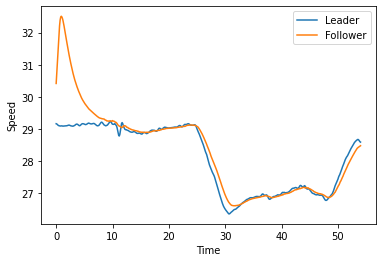

(4.222759644454656, 0.6369089482961263, 0.5172744945138611)


In [18]:
### Test module

if __name__ == '__main__':
    # Read a csv file as numpy matrix: return ndarray          
    file_path = '../data/CIVIC/Trajectory/'     

    data_leader_pos = np.loadtxt(open(file_path + 'Leading Position.csv', "rb"), delimiter=",", skiprows=0)
    data_leader_spd = np.loadtxt(open(file_path + 'Leading Speed.csv', "rb"), delimiter=",", skiprows=0)
    data_leader_acc = np.loadtxt(open(file_path + 'Leading Acc.csv', "rb"), delimiter=",", skiprows=0)
    # data_leader_jer = np.loadtxt(open(file_path + 'Leading Jerk.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_pos = np.loadtxt(open(file_path + 'Following Position.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_spd = np.loadtxt(open(file_path + 'Following Speed.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_acc = np.loadtxt(open(file_path + 'Following Acc.csv', "rb"), delimiter=",", skiprows=0)
    # data_follower_jer = np.loadtxt(open(file_path + 'Following Jerk.csv', "rb"), delimiter=",", skiprows=0)

    
    leader_vec = TrajVector(sample_time_step = 0.1)
    leader_vec.load(data_leader_pos, data_leader_spd, data_leader_acc, [])
    # leader_vec.show(0)
    
    follower_vec = TrajVector(sample_time_step = 0.1)
    follower_vec.load(data_follower_pos, data_follower_spd, data_follower_acc, [])
    # follower_vec.show(0)
    
    test_model = 'MPC'
    if test_model == 'LL':
        my_model = CF_Model(0.1, 'LL')
        parameter = [1, 0.3, 1.5, 4]
        follower_sim = my_model.single_simulation(
            leader_vec.veh[0], follower_vec.veh[0], parameter)
    if test_model == 'LLCS':
        my_model = CF_Model(0.1, 'LLCS')
        parameter = [10, 0.3, 1.5] ###S0 4+5
        follower_sim = my_model.single_simulation(
            leader_vec.veh[0], follower_vec.veh[0], parameter)
    if test_model == 'FVM':
        my_model = CF_Model(0.1, 'FVM')
        # parameter = [0.005, 1, 0.005, 0.005, 20, 20]
        parameter = [200, 1, 0.005, 0.005, 20, 20]
        follower_sim = my_model.single_simulation(
            leader_vec.veh[0], follower_vec.veh[0], parameter)
    if test_model == 'FVM2':
        my_model = CF_Model(0.1, 'FVM2')
        parameter = [0.005, 1, 0.005, 0.005, 20, 20]
        follower_sim = my_model.single_simulation(
            leader_vec.veh[0], follower_vec.veh[0], parameter)
    if test_model == 'MPC':    
        my_model = CF_Model(0.1, 'MPC')
        parameter = [1, 0.5, 1, 5, -3, 3]
        follower_sim = my_model.single_simulation(
            leader_vec.veh[0], follower_vec.veh[0], parameter)
    if test_model == 'IDM':    
        my_model = CF_Model(0.1, 'IDM') 
        parameter = [1.0, 3.2, 70, 1.5, 2.4, 4]          #####Unit
        follower_sim = my_model.single_simulation(
            leader_vec.veh[12], follower_vec.veh[12], parameter)
    if test_model == 'OVM':    
        my_model = CF_Model(0.1, 'OVM') 
        parameter = [0.85, 6.75, 22.91, 0.13, 1.57, 0]          #####Unit
        follower_sim = my_model.single_simulation(
            leader_vec.veh[0], follower_vec.veh[0], parameter)
    if test_model == 'GFM':    
        my_model = CF_Model(0.1, 'GFM') 
        parameter = [0.41, 1, 6.75, 22.91, 0.13, 1.57, 0]          #####Unit
        follower_sim = my_model.single_simulation(
            leader_vec.veh[0], follower_vec.veh[0], parameter)

    TrajPair(leader_vec.veh[0],follower_sim).show('s')
    # TrajPair(follower_vec.veh[0],follower_sim).show()
    print(follower_sim.distance(follower_vec.veh[0]))


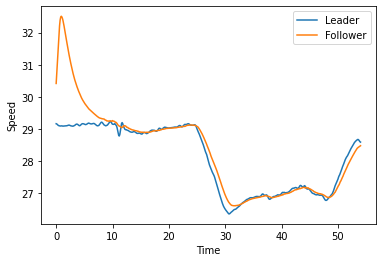

(4.222759644454656, 0.6369089482961263, 0.5172744945138611)


In [19]:
### Compute TTC
if __name__ == '__main__':
    # Read a csv file as numpy matrix: return ndarray          
    file_path = '../data/CIVIC/Trajectory/'     

    data_leader_pos = np.loadtxt(open(file_path + 'Leading Position.csv', "rb"), delimiter=",", skiprows=0)
    data_leader_spd = np.loadtxt(open(file_path + 'Leading Speed.csv', "rb"), delimiter=",", skiprows=0)
    data_leader_acc = np.loadtxt(open(file_path + 'Leading Acc.csv', "rb"), delimiter=",", skiprows=0)
    # data_leader_jer = np.loadtxt(open(file_path + 'Leading Jerk.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_pos = np.loadtxt(open(file_path + 'Following Position.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_spd = np.loadtxt(open(file_path + 'Following Speed.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_acc = np.loadtxt(open(file_path + 'Following Acc.csv', "rb"), delimiter=",", skiprows=0)
    # data_follower_jer = np.loadtxt(open(file_path + 'Following Jerk.csv', "rb"), delimiter=",", skiprows=0)

    
    leader_vec = TrajVector(sample_time_step = 0.1)
    leader_vec.load(data_leader_pos, data_leader_spd, data_leader_acc, [])
    # leader_vec.show(0)
    
    follower_vec = TrajVector(sample_time_step = 0.1)
    follower_vec.load(data_follower_pos, data_follower_spd, data_follower_acc, [])
    # follower_vec.show(0)
    
    test_model = 'MPC'
    
    if test_model == 'LL':
        my_model = CF_Model(0.1, 'LL')
        parameter = [1, 0.3, 1.5, 4]
        follower_sim = my_model.single_simulation(
            leader_vec.veh[0], follower_vec.veh[0], parameter)

    if test_model == 'MPC':    
        my_model = CF_Model(0.1, 'MPC')
        parameter = [1, 0.5, 1, 5, -3, 3]
        follower_sim = my_model.single_simulation(
            leader_vec.veh[0], follower_vec.veh[0], parameter)

    TrajPair(leader_vec.veh[0],follower_sim).show('s')
    # TrajPair(follower_vec.veh[0],follower_sim).show()
    print(follower_sim.distance(follower_vec.veh[0]))


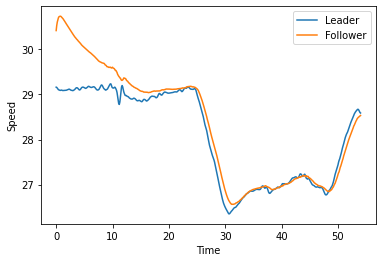

(4.348918537584817, 0.5764072530349572, 0.3595453354169412)


In [23]:
### Test module

if __name__ == '__main__':
    # Read a csv file as numpy matrix: return ndarray          
    file_path = '../data/CIVIC/Trajectory/'     

    data_leader_pos = np.loadtxt(open(file_path + 'Leading Position.csv', "rb"), delimiter=",", skiprows=0)
    data_leader_spd = np.loadtxt(open(file_path + 'Leading Speed.csv', "rb"), delimiter=",", skiprows=0)
    data_leader_acc = np.loadtxt(open(file_path + 'Leading Acc.csv', "rb"), delimiter=",", skiprows=0)
    # data_leader_jer = np.loadtxt(open(file_path + 'Leading Jerk.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_pos = np.loadtxt(open(file_path + 'Following Position.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_spd = np.loadtxt(open(file_path + 'Following Speed.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_acc = np.loadtxt(open(file_path + 'Following Acc.csv', "rb"), delimiter=",", skiprows=0)
    # data_follower_jer = np.loadtxt(open(file_path + 'Following Jerk.csv', "rb"), delimiter=",", skiprows=0)

    
    leader_vec = TrajVector(sample_time_step = 0.1)
    leader_vec.load(data_leader_pos, data_leader_spd, data_leader_acc, [])
    # leader_vec.show(0)
    
    follower_vec = TrajVector(sample_time_step = 0.1)
    follower_vec.load(data_follower_pos, data_follower_spd, data_follower_acc, [])
    # follower_vec.show(0)
    
    test_model = 'LL'
    if test_model == 'LL':
        my_model = CF_Model(0.1, 'LL')
        parameter = [1, 0.3, 1.5, 4]
        follower_sim = my_model.single_simulation(
            leader_vec.veh[0], follower_vec.veh[0], parameter)
    if test_model == 'LLCS':
        my_model = CF_Model(0.1, 'LLCS')
        parameter = [9, 0.3, 1.5] ###S0 4+5
        follower_sim = my_model.single_simulation(
            leader_vec.veh[0], follower_vec.veh[0], parameter)
    if test_model == 'FVM':
        my_model = CF_Model(0.1, 'FVM')
        # parameter = [0.005, 1, 0.005, 0.005, 20, 20]
        parameter = [200, 1, 0.005, 0.005, 20, 20]
        follower_sim = my_model.single_simulation(
            leader_vec.veh[0], follower_vec.veh[0], parameter)
    if test_model == 'FVM2':
        my_model = CF_Model(0.1, 'FVM2')
        parameter = [0.005, 1, 0.005, 0.005, 20, 20]
        follower_sim = my_model.single_simulation(
            leader_vec.veh[0], follower_vec.veh[0], parameter)
    if test_model == 'MPC':    
        my_model = CF_Model(0.1, 'MPC')
        parameter = [1, 0.5, 1, 5, -3, 3]
        follower_sim = my_model.single_simulation(
            leader_vec.veh[0], follower_vec.veh[0], parameter)
    if test_model == 'IDM':    
        my_model = CF_Model(0.1, 'IDM') 
        parameter = [1.0, 3.2, 70, 1.5, 2.4, 4]          #####Unit
        follower_sim = my_model.single_simulation(
            leader_vec.veh[12], follower_vec.veh[12], parameter)
    if test_model == 'OVM':    
        my_model = CF_Model(0.1, 'OVM') 
        parameter = [0.85, 6.75, 22.91, 0.13, 1.57, 0]          #####Unit
        follower_sim = my_model.single_simulation(
            leader_vec.veh[0], follower_vec.veh[0], parameter)
    if test_model == 'GFM':    
        my_model = CF_Model(0.1, 'GFM') 
        parameter = [0.41, 1, 6.75, 22.91, 0.13, 1.57, 0]          #####Unit
        follower_sim = my_model.single_simulation(
            leader_vec.veh[0], follower_vec.veh[0], parameter)

    TrajPair(leader_vec.veh[0],follower_sim).show('s')
    # TrajPair(follower_vec.veh[0],follower_sim).show()
    print(follower_sim.distance(follower_vec.veh[0]))

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:630: ComplexWarning: Casting complex values to real discards the imaginary part


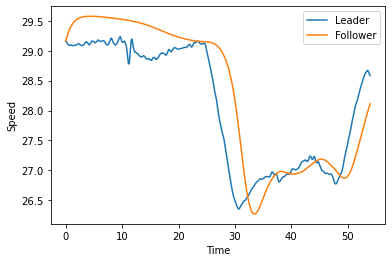

(5.208085960918012, 0.4399734725388471, 0.33893580966434106)


In [54]:
### Test module

if __name__ == '__main__':
    # Read a csv file as numpy matrix: return ndarray          
    file_path = '../data/CIVIC/Trajectory/'     

    data_leader_pos = np.loadtxt(open(file_path + 'Leading Position.csv', "rb"), delimiter=",", skiprows=0)
    data_leader_spd = np.loadtxt(open(file_path + 'Leading Speed.csv', "rb"), delimiter=",", skiprows=0)
    data_leader_acc = np.loadtxt(open(file_path + 'Leading Acc.csv', "rb"), delimiter=",", skiprows=0)
    # data_leader_jer = np.loadtxt(open(file_path + 'Leading Jerk.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_pos = np.loadtxt(open(file_path + 'Following Position.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_spd = np.loadtxt(open(file_path + 'Following Speed.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_acc = np.loadtxt(open(file_path + 'Following Acc.csv', "rb"), delimiter=",", skiprows=0)
    # data_follower_jer = np.loadtxt(open(file_path + 'Following Jerk.csv', "rb"), delimiter=",", skiprows=0)

    
    leader_vec = TrajVector(sample_time_step = 0.1)
    leader_vec.load(data_leader_pos, data_leader_spd, data_leader_acc, [])
    # leader_vec.show(0)
    
    follower_vec = TrajVector(sample_time_step = 0.1)
    follower_vec.load(data_follower_pos, data_follower_spd, data_follower_acc, [])
    # follower_vec.show(0)
    
    test_model = 'OVM'
    if test_model == 'LL':
        my_model = CF_Model(0.1, 'LL')
        parameter = [1, 0.3, 1.5, 4]
        follower_sim = my_model.single_simulation(
            leader_vec.veh[0], follower_vec.veh[0], parameter)
    if test_model == 'FVM':
        my_model = CF_Model(0.1, 'FVM')
        # parameter = [0.005, 1, 0.005, 0.005, 20, 20]
        parameter = [200, 1, 0.005, 0.005, 20, 20]
        follower_sim = my_model.single_simulation(
            leader_vec.veh[0], follower_vec.veh[0], parameter)
    if test_model == 'FVM2':
        my_model = CF_Model(0.1, 'FVM2')
        parameter = [0.005, 1, 0.005, 0.005, 20, 20]
        follower_sim = my_model.single_simulation(
            leader_vec.veh[0], follower_vec.veh[0], parameter)
    if test_model == 'MPC':    
        my_model = CF_Model(0.1, 'MPC')
        parameter = [1, 0.5, 1, 5, -3, 3]
        follower_sim = my_model.single_simulation(
            leader_vec.veh[0], follower_vec.veh[0], parameter)
    if test_model == 'IDM':    
        my_model = CF_Model(0.1, 'IDM') 
        parameter = [1.0, 3.2, 70, 1.5, 2.4, 4]          #####Unit
        follower_sim = my_model.single_simulation(
            leader_vec.veh[12], follower_vec.veh[12], parameter)
    if test_model == 'OVM':    
        my_model = CF_Model(0.1, 'OVM') 
        parameter = [0.85, 6.75, 22.91, 0.13, 1.57, 0]          #####Unit
        follower_sim = my_model.single_simulation(
            leader_vec.veh[0], follower_vec.veh[0], parameter)
    if test_model == 'GFM':    
        my_model = CF_Model(0.1, 'GFM') 
        parameter = [0.41, 1, 6.75, 22.91, 0.13, 1.57, 0]          #####Unit
        follower_sim = my_model.single_simulation(
            leader_vec.veh[0], follower_vec.veh[0], parameter)

    TrajPair(leader_vec.veh[0],follower_sim).show('s')
    # TrajPair(follower_vec.veh[0],follower_sim).show()
    print(follower_sim.distance(follower_vec.veh[0]))

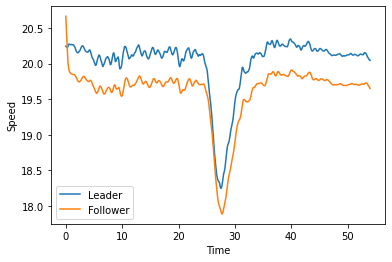

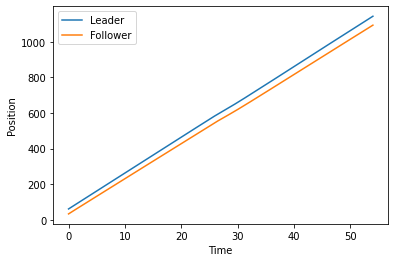

(11.732163007792252, 0.5062156248672008, 0.5430837571925714)


In [19]:
### Test module

if __name__ == '__main__':
    # Read a csv file as numpy matrix: return ndarray          
    file_path = '../data/CIVIC/Trajectory/'     

    data_leader_pos = np.loadtxt(open(file_path + 'Leading Position.csv', "rb"), delimiter=",", skiprows=0)
    data_leader_spd = np.loadtxt(open(file_path + 'Leading Speed.csv', "rb"), delimiter=",", skiprows=0)
    data_leader_acc = np.loadtxt(open(file_path + 'Leading Acc.csv', "rb"), delimiter=",", skiprows=0)
    # data_leader_jer = np.loadtxt(open(file_path + 'Leading Jerk.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_pos = np.loadtxt(open(file_path + 'Following Position.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_spd = np.loadtxt(open(file_path + 'Following Speed.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_acc = np.loadtxt(open(file_path + 'Following Acc.csv', "rb"), delimiter=",", skiprows=0)
    # data_follower_jer = np.loadtxt(open(file_path + 'Following Jerk.csv', "rb"), delimiter=",", skiprows=0)

    
    leader_vec = TrajVector(sample_time_step = 0.1)
    leader_vec.load(data_leader_pos, data_leader_spd, data_leader_acc, [])
    # leader_vec.show(0)
    
    follower_vec = TrajVector(sample_time_step = 0.1)
    follower_vec.load(data_follower_pos, data_follower_spd, data_follower_acc, [])
    # follower_vec.show(0)
    
    test_model = 'GFM'
    
    if test_model == 'GFM':    
        my_model = CF_Model(0.1, 'GFM') 
        #parameter = [0.0915, 5, 18.6674, 15.2754, 0.2567, 15.0656, 0]          #####Unit
        parameter = [0.0695, 4, 11.8562, 16.1474, 0.2882, 20.9403, 0]
        follower_sim = my_model.single_simulation(
            leader_vec.veh[47], follower_vec.veh[47], parameter)



    TrajPair(leader_vec.veh[47],follower_sim).show('s')
    # TrajPair(follower_vec.veh[0],follower_sim).show()
    TrajPair(leader_vec.veh[47],follower_sim).show('p')
    print(follower_sim.distance(follower_vec.veh[47]))

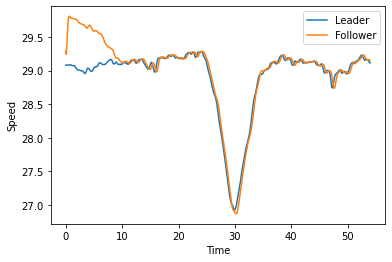

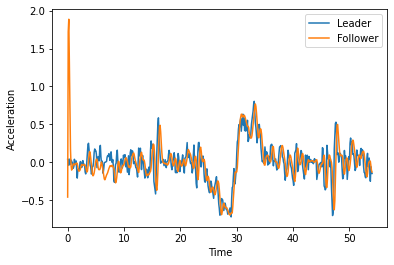

(4.598929639755377, 0.5735943702843117, 0.39523189382176876)


In [16]:
### Test module

if __name__ == '__main__':
    # Read a csv file as numpy matrix: return ndarray          
    file_path = '../data/CIVIC/Trajectory/'     

    data_leader_pos = np.loadtxt(open(file_path + 'Leading Position.csv', "rb"), delimiter=",", skiprows=0)
    data_leader_spd = np.loadtxt(open(file_path + 'Leading Speed.csv', "rb"), delimiter=",", skiprows=0)
    data_leader_acc = np.loadtxt(open(file_path + 'Leading Acc.csv', "rb"), delimiter=",", skiprows=0)
    # data_leader_jer = np.loadtxt(open(file_path + 'Leading Jerk.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_pos = np.loadtxt(open(file_path + 'Following Position.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_spd = np.loadtxt(open(file_path + 'Following Speed.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_acc = np.loadtxt(open(file_path + 'Following Acc.csv', "rb"), delimiter=",", skiprows=0)
    # data_follower_jer = np.loadtxt(open(file_path + 'Following Jerk.csv', "rb"), delimiter=",", skiprows=0)

    
    leader_vec = TrajVector(sample_time_step = 0.1)
    leader_vec.load(data_leader_pos, data_leader_spd, data_leader_acc, [])
    # leader_vec.show(0)
    
    follower_vec = TrajVector(sample_time_step = 0.1)
    follower_vec.load(data_follower_pos, data_follower_spd, data_follower_acc, [])
    # follower_vec.show(0)
    
    test_model = 'FVM'
    ##self.parameter_name = ['tau', 'lambda', 'V1', 'V2', 'lint', 'beta']
   
    if test_model == 'FVM':
        my_model = CF_Model(0.1, 'FVM')
        # parameter = [0.005, 1, 0.005, 0.005, 20, 20]
        parameter = [2, 3, 14, 20, 1.6672, 15]
        follower_sim = my_model.single_simulation(
            leader_vec.veh[60], follower_vec.veh[60], parameter)

    TrajPair(leader_vec.veh[60],follower_sim).show('p')
    TrajPair(leader_vec.veh[60],follower_sim).show('s')
    # TrajPair(follower_vec.veh[0],follower_sim).show()
    TrajPair(leader_vec.veh[60],follower_sim).show('a')
    print(follower_sim.distance(follower_vec.veh[60]))


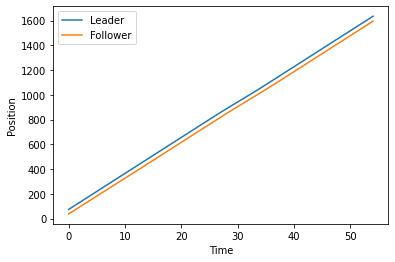

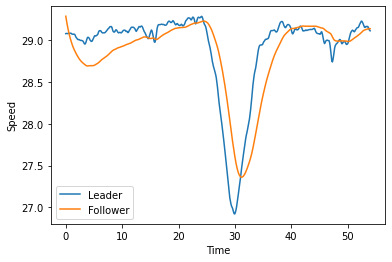

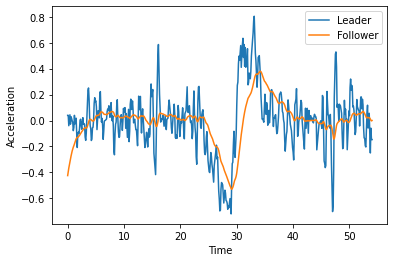

(3.5262547273690363, 0.3474413552256515, 0.30518241804923185)


In [11]:
### Test module

if __name__ == '__main__':
    # Read a csv file as numpy matrix: return ndarray          
    file_path = '../data/CIVIC/Trajectory/'     

    data_leader_pos = np.loadtxt(open(file_path + 'Leading Position.csv', "rb"), delimiter=",", skiprows=0)
    data_leader_spd = np.loadtxt(open(file_path + 'Leading Speed.csv', "rb"), delimiter=",", skiprows=0)
    data_leader_acc = np.loadtxt(open(file_path + 'Leading Acc.csv', "rb"), delimiter=",", skiprows=0)
    # data_leader_jer = np.loadtxt(open(file_path + 'Leading Jerk.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_pos = np.loadtxt(open(file_path + 'Following Position.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_spd = np.loadtxt(open(file_path + 'Following Speed.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_acc = np.loadtxt(open(file_path + 'Following Acc.csv', "rb"), delimiter=",", skiprows=0)
    # data_follower_jer = np.loadtxt(open(file_path + 'Following Jerk.csv', "rb"), delimiter=",", skiprows=0)

    
    leader_vec = TrajVector(sample_time_step = 0.1)
    leader_vec.load(data_leader_pos, data_leader_spd, data_leader_acc, [])
    # leader_vec.show(0)
    
    follower_vec = TrajVector(sample_time_step = 0.1)
    follower_vec.load(data_follower_pos, data_follower_spd, data_follower_acc, [])
    # follower_vec.show(0)
    
    test_model = 'IDM'
    ##self.parameter_name = ['tau', 'lambda', 'V1', 'V2', 'lint', 'beta']
   
    if test_model == 'IDM':    
        my_model = CF_Model(0.1, 'IDM') 
        parameter = [1.5138, 3.2, 50, 1.2, 3, 4.4006]          #####Unit
        follower_sim = my_model.single_simulation(
            leader_vec.veh[60], follower_vec.veh[60], parameter)

    TrajPair(leader_vec.veh[60],follower_sim).show('p')
    TrajPair(leader_vec.veh[60],follower_sim).show('s')
    # TrajPair(follower_vec.veh[0],follower_sim).show()
    TrajPair(leader_vec.veh[60],follower_sim).show('a')
    print(follower_sim.distance(follower_vec.veh[60]))
